In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
# !pip install scikit-learn
from sklearn.utils import shuffle

150 150 3


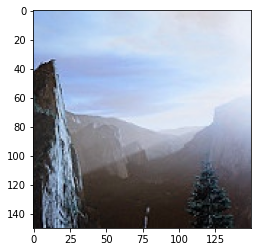

In [2]:
img = cv2.imread('seg_train/mountain/234.jpg')

height, width, channels = img.shape

print(height, width, channels)

plt.imshow(img)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SIZE = (150,150)
BATCH_SIZE = 32

train_dir = 'seg_train'
test_dir = 'seg_test'

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

print("Training Images")
train_data = train_datagen.flow_from_directory(train_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle=True)

print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle = True)


Training Images
Found 14034 images belonging to 6 classes.
Testing Images
Found 3000 images belonging to 6 classes.


In [44]:
# def load_data():
#     datasets = ['seg_train', 'seg_test']
#     output = []

#     for dataset in datasets:
#         images = []
#         labels = []

#         for folder in os.listdir(dataset):
#             label = classLabels[folder] 

#             for file in os.listdir(os.path.join(dataset, folder)):
#                 img_path = os.path.join(os.path.join(dataset, folder), file)

#                 image = cv2.imread(img_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#                 images.append(image)
#                 labels.append(label)

#             images = np.array(images, dtype = 'float32')
#             labels = np.array(labels, dtype = 'int32')

#             output.append((images, labels))
#     return output

In [9]:
labels = {value: key for key, value in train_data.class_indices.items()}

for key, value in labels.items():
    print(f"{key} : {value}")

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [10]:
print(labels)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


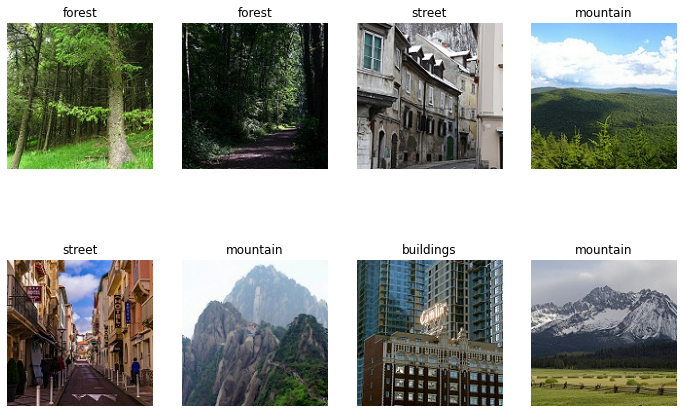

In [11]:
idx = 0
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(12, 8))

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_data[0][1][idx])]
        ax[i,j].set_title(f"{label}")
        ax[i, j].imshow(train_data[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.show()

In [12]:
_, train_counts = np.unique(train_data.labels, return_counts= True)
_, test_counts = np.unique(test_data.labels, return_counts= True)

In [13]:
print(train_counts)

[2191 2271 2404 2512 2274 2382]


In [14]:
print(test_counts)

[437 474 553 525 510 501]


In [15]:
labels.values()

dict_values(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

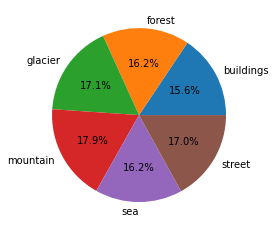

In [16]:
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0), autopct='%1.1f%%',labels = labels.values())
plt.show()

In [17]:
from tensorflow.keras import backend as K

def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())


def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [41]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), padding='valid', activation='relu', input_shape = (150, 150, 3)))
    model.add(layers.Conv2D(filters=200, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(5,5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = 0.8))
    model.add(layers.Conv2D(filters=180, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(5,5))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate = 0.5))
    model.add(layers.Dense(6, activation='softmax'))

    model.compile(optimizer = optimizers.Adam(learning_rate= 0.0010), loss = 'categorical_crossentropy', 
                                                metrics = ['accuracy',sensitivity, precision,recall,specificity])
    
    return model

In [42]:
model = create_model()

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 146, 146, 256)     19456     
                                                                 
 conv2d_31 (Conv2D)          (None, 144, 144, 200)     461000    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 200)      0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 200)      800       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 28, 28, 200)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 26, 26, 180)      

In [44]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [45]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_learningRate = ReduceLROnPlateau(monitor = 'val_loss', factor = np.sqrt(0.1), patience = 5)

In [46]:
history = model.fit(train_data,
                    epochs = 30,
                    validation_data = test_data,
                    callbacks = reduce_learningRate,
                    )

Epoch 1/30
439/439 [==============================] - 84s 190ms/step - loss: 1.2097 - accuracy: 0.5175 - sensitivity: 0.3164 - precision: 0.6723 - recall: 0.3164 - specificity: 0.9718 - val_loss: 0.9866 - val_accuracy: 0.6070 - val_sensitivity: 0.4716 - val_precision: 0.7151 - val_recall: 0.4716 - val_specificity: 0.9628 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 83s 190ms/step - loss: 0.9485 - accuracy: 0.6431 - sensitivity: 0.4852 - precision: 0.7515 - recall: 0.4852 - specificity: 0.9679 - val_loss: 1.4903 - val_accuracy: 0.4603 - val_sensitivity: 0.3941 - val_precision: 0.5076 - val_recall: 0.3941 - val_specificity: 0.9230 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 84s 190ms/step - loss: 0.7974 - accuracy: 0.7037 - sensitivity: 0.5910 - precision: 0.7832 - recall: 0.5910 - specificity: 0.9672 - val_loss: 0.9952 - val_accuracy: 0.6333 - val_sensitivity: 0.5690 - val_precision: 0.6674 - val_recall: 0.5690 - val_specificity: 0.9432 - lr:

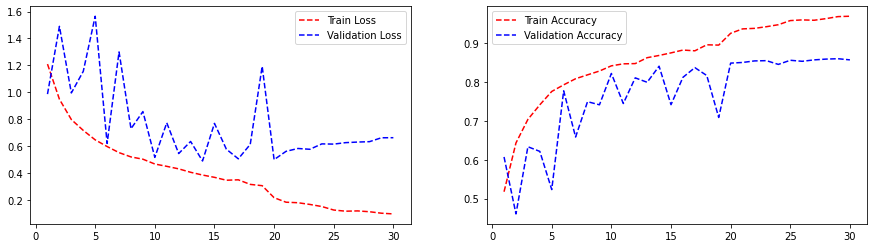

In [90]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_loss, 'r--')
axs[0].plot(epoch_count, val_loss, 'b--')
axs[0].legend(['Train Loss', 'Validation Loss'])

axs[1].plot(epoch_count, train_accuracy, 'r--')
axs[1].plot(epoch_count, val_accuracy, 'b--')
axs[1].legend(['Train Accuracy', 'Validation Accuracy'])

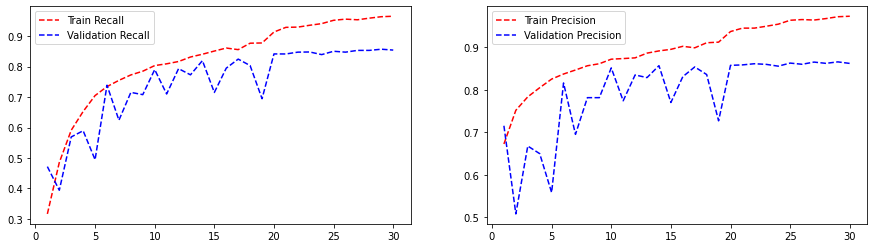

In [91]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_recall = history.history['recall']
val_recall = history.history['val_recall']

train_precision = history.history['precision']
val_precision = history.history['val_precision']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_recall, 'r--')
axs[0].plot(epoch_count, val_recall, 'b--')
axs[0].legend(['Train Recall', 'Validation Recall'])

axs[1].plot(epoch_count, train_precision, 'r--')
axs[1].plot(epoch_count, val_precision, 'b--')
axs[1].legend(['Train Precision', 'Validation Precision'])

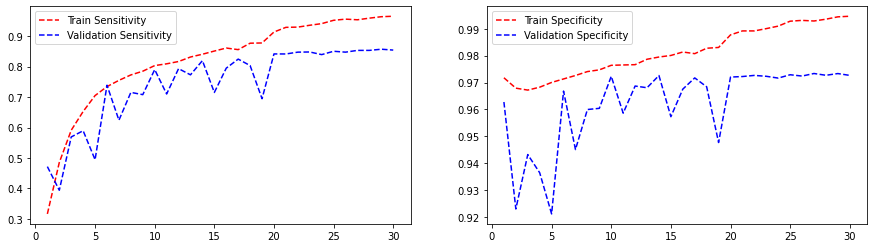

In [92]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_sensitivity = history.history['sensitivity']
val_sensitivity = history.history['val_sensitivity']

train_specificity = history.history['specificity']
val_specificity  = history.history['val_specificity']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_sensitivity, 'r--')
axs[0].plot(epoch_count, val_sensitivity, 'b--')
axs[0].legend(['Train Sensitivity', 'Validation Sensitivity'])

axs[1].plot(epoch_count, train_specificity, 'r--')
axs[1].plot(epoch_count, val_specificity, 'b--')
axs[1].legend(['Train Specificity', 'Validation Specificity'])

In [73]:
# tf.keras.models.save_model(model, 'model_v1.h5')

tf.keras.models.save_model(model, 'model_v2.h5') # Extra dropout layer in attempt to reduce overfitting

In [85]:
np.save('history1.npy', history.history)

In [51]:
# history = np.load('history1.npy', allow_pickle=True).item()

## On Test Dataset

In [31]:
dependencies = {
    'sensitivity' : sensitivity,
    'precision' : precision,
    'recall' : recall,
    'specificity' : specificity
}

load_model = tf.keras.models.load_model('model_v2.h5', custom_objects= dependencies)

In [32]:
pred_dir = 'seg_test'

pred_datagen = ImageDataGenerator(rescale = 1/255)

print("Prediction Images")
pred_data = pred_datagen.flow_from_directory(pred_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle=True)

Prediction Images
Found 3000 images belonging to 6 classes.


In [33]:
prediction = load_model.predict(pred_data)

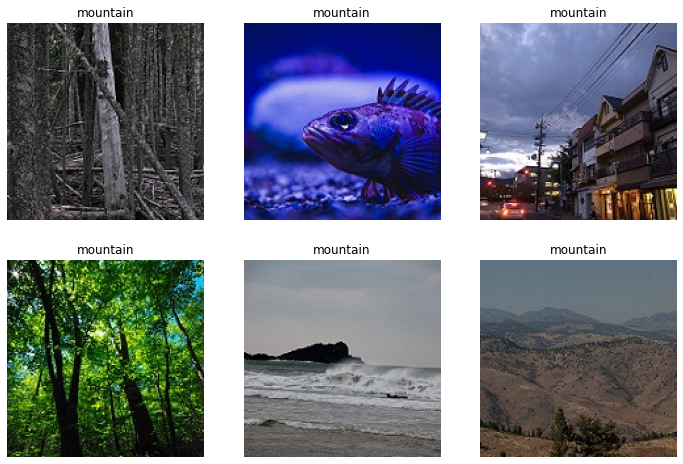

In [18]:
idx = 0
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 8))

for i in range(2):
    for j in range(3):
        predicted_label = labels[np.argmax(prediction[idx])]
        ax[i,j].set_title(f"{label}")
        ax[i, j].imshow(pred_data[30][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.show()

In [34]:
print(load_model.metrics_names)

['loss', 'accuracy', 'sensitivity', 'precision', 'recall', 'specificity']


In [35]:
test_loss, test_accuracy, test_sensitivity, test_precision, test_recall, test_specificity = load_model.evaluate(pred_data, batch_size=32)

94/94 [==============================] - 5s 45ms/step - loss: 0.6624 - accuracy: 0.8570 - sensitivity: 0.8546 - precision: 0.8624 - recall: 0.8546 - specificity: 0.9727


In [21]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Sensitivity: {test_sensitivity}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test Specificity: {test_specificity}")

Test Loss: 0.6623975038528442
Test Accuracy: 0.8569999933242798
Test Sensitivity: 0.8548315167427063
Test Precision: 0.8626664876937866
Test Recall: 0.8548315167427063
Test Specificity: 0.9727614521980286


## Transfer Learning and Comparative Analysis

### InceptionV3

In [65]:
# inception_url="https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [77]:
# import tensorflow_hub as hub

# def create_model (model_url,num_classes=7):
#   feature_extractor_layer = hub.KerasLayer(model_url,
#                                            trainable=True,
#                                            name='feature_extraction_layer',
#                                            input_shape = IMAGE_SIZE+(3,))
#   model=tf.keras.Sequential([
#                              feature_extractor_layer,
#                              layers.Dense(num_classes,activation='softmax',name='output_layers')
#   ])
#   return model

In [ ]:
# inception_model = create_model(inception_url,num_classes = 6)
# inception_model.summary()
# inception_model.compile(loss='categorical_crossentropy',
#                      optimizer=tf.keras.optimizers.Adam(),
#                      metrics=['accuracy',sensitivity, precision,recall,specificity])

In [ ]:
# inceptionet_history = inception_model.fit(train_data,
#                                   epochs=15,
#                                   validation_data=test_data)                              

In [102]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_base_model = InceptionV3(input_shape = (150,150,3), include_top = False, weights = "imagenet")
inception_base_model.trainable = False

inputs = tf.keras.Input(shape=(150,150,3))

x = inception_base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(6, activation='softmax')(x)

inception_model = tf.keras.Model(inputs, outputs)

In [103]:
inception_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_26 (Dense)            (None, 6)                 12294     
                                                                 
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [104]:
inception_model.compile(loss = "categorical_crossentropy", metrics = ['accuracy', sensitivity, precision,recall,specificity])

In [105]:
history_inception = inception_model.fit(train_data,
                    epochs = 30,
                    validation_data = test_data,
                    callbacks = reduce_learningRate,
                    )

Epoch 1/30
439/439 [==============================] - 14s 26ms/step - loss: 0.4939 - accuracy: 0.8360 - sensitivity: 0.7973 - precision: 0.8533 - recall: 0.7973 - specificity: 0.9737 - val_loss: 0.3525 - val_accuracy: 0.8830 - val_sensitivity: 0.8647 - val_precision: 0.8938 - val_recall: 0.8647 - val_specificity: 0.9795 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 11s 25ms/step - loss: 0.3424 - accuracy: 0.8846 - sensitivity: 0.8731 - precision: 0.8934 - recall: 0.8731 - specificity: 0.9792 - val_loss: 0.3202 - val_accuracy: 0.8930 - val_sensitivity: 0.8801 - val_precision: 0.8988 - val_recall: 0.8801 - val_specificity: 0.9802 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 11s 25ms/step - loss: 0.2952 - accuracy: 0.9005 - sensitivity: 0.8923 - precision: 0.9064 - recall: 0.8923 - specificity: 0.9816 - val_loss: 0.3143 - val_accuracy: 0.8937 - val_sensitivity: 0.8850 - val_precision: 0.9006 - val_recall: 0.8850 - val_specificity: 0.9804 - lr: 0.

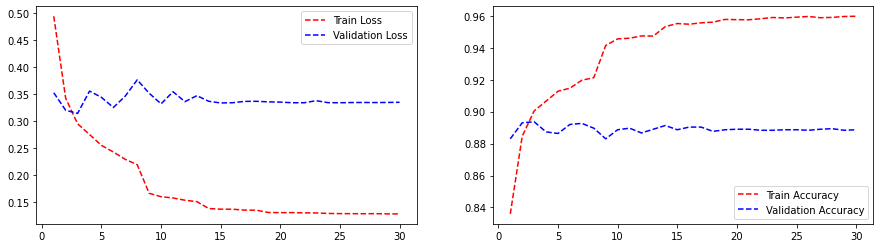

In [106]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_accuracy_inception = history_inception.history['accuracy']
val_accuracy_inception = history_inception.history['val_accuracy']

train_loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_loss_inception, 'r--')
axs[0].plot(epoch_count, val_loss_inception, 'b--')
axs[0].legend(['Train Loss', 'Validation Loss'])

axs[1].plot(epoch_count, train_accuracy_inception, 'r--')
axs[1].plot(epoch_count, val_accuracy_inception, 'b--')
axs[1].legend(['Train Accuracy', 'Validation Accuracy'])

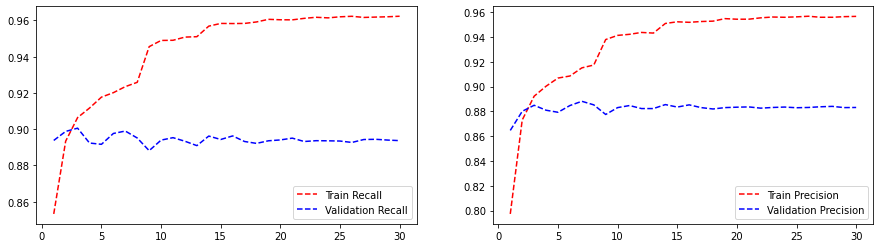

In [107]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_recall_inception = history_inception.history['recall']
val_recall_inception = history_inception.history['val_recall']

train_precision_inception = history_inception.history['precision']
val_precision_inception = history_inception.history['val_precision']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_precision_inception, 'r--')
axs[0].plot(epoch_count, val_precision_inception, 'b--')
axs[0].legend(['Train Recall', 'Validation Recall'])

axs[1].plot(epoch_count, train_recall_inception, 'r--')
axs[1].plot(epoch_count, val_recall_inception, 'b--')
axs[1].legend(['Train Precision', 'Validation Precision'])

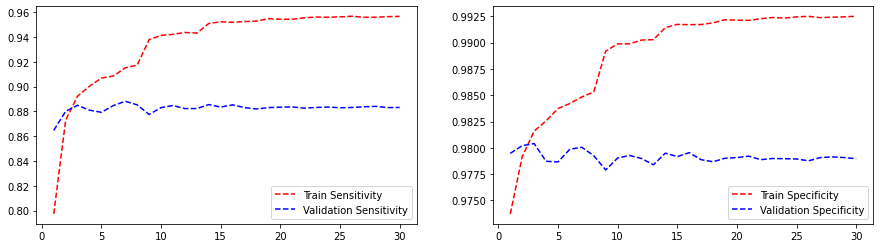

In [108]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_sensitivity_inception = history_inception.history['sensitivity']
val_sensitivity_inception = history_inception.history['val_sensitivity']

train_specificity_inception = history_inception.history['specificity']
val_specificity_inception  = history_inception.history['val_specificity']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_sensitivity_inception, 'r--')
axs[0].plot(epoch_count, val_sensitivity_inception, 'b--')
axs[0].legend(['Train Sensitivity', 'Validation Sensitivity'])

axs[1].plot(epoch_count, train_specificity_inception, 'r--')
axs[1].plot(epoch_count, val_specificity_inception, 'b--')
axs[1].legend(['Train Specificity', 'Validation Specificity'])

In [109]:
tf.keras.models.save_model(inception_model, 'inception_model.h5')

In [22]:
# inception_model = tf.keras.models.load_model('inception_model.h5', custom_objects= dependencies)

In [110]:
np.save('history_inception.npy', history_inception.history)

In [23]:
# history_inception = np.load('history_inception.npy', allow_pickle=True).item()

### VGG16

In [111]:
from tensorflow.keras.applications import VGG16

vgg_base_model = VGG16(input_shape = (150, 150, 3), include_top = False, weights = "imagenet")
vgg_base_model.trainable = False

inputs = tf.keras.Input(shape=(150,150,3))

x = vgg_base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(6, activation='softmax')(x)

vgg_model = tf.keras.Model(inputs, outputs)

In [112]:
vgg_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_27 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [113]:
vgg_model.compile(loss = "categorical_crossentropy", metrics = ['accuracy', sensitivity, precision,recall,specificity])

In [114]:
history_vgg = vgg_model.fit(train_data,
                    epochs = 30,
                    validation_data = test_data,
                    callbacks = reduce_learningRate,
                    )

Epoch 1/30
439/439 [==============================] - 23s 50ms/step - loss: 0.8795 - accuracy: 0.7360 - sensitivity: 0.4179 - precision: 0.7617 - recall: 0.4179 - specificity: 0.9899 - val_loss: 0.5777 - val_accuracy: 0.8097 - val_sensitivity: 0.7037 - val_precision: 0.8794 - val_recall: 0.7037 - val_specificity: 0.9809 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 22s 50ms/step - loss: 0.5160 - accuracy: 0.8264 - sensitivity: 0.7547 - precision: 0.8792 - recall: 0.7547 - specificity: 0.9792 - val_loss: 0.4746 - val_accuracy: 0.8353 - val_sensitivity: 0.7778 - val_precision: 0.8778 - val_recall: 0.7778 - val_specificity: 0.9783 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 22s 50ms/step - loss: 0.4509 - accuracy: 0.8442 - sensitivity: 0.7984 - precision: 0.8823 - recall: 0.7984 - specificity: 0.9787 - val_loss: 0.4381 - val_accuracy: 0.8457 - val_sensitivity: 0.7981 - val_precision: 0.8743 - val_recall: 0.7981 - val_specificity: 0.9771 - lr: 0.

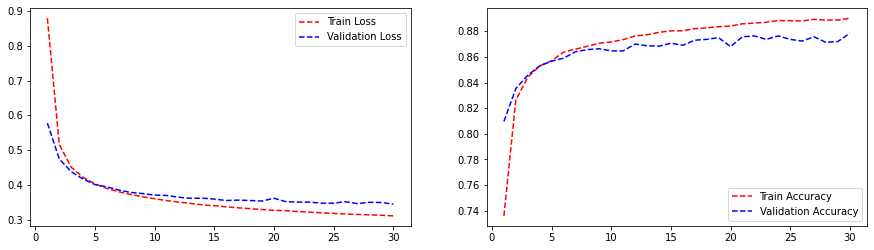

In [115]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_accuracy_vgg = history_vgg.history['accuracy']
val_accuracy_vgg= history_vgg.history['val_accuracy']

train_loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_loss_vgg, 'r--')
axs[0].plot(epoch_count, val_loss_vgg, 'b--')
axs[0].legend(['Train Loss', 'Validation Loss'])

axs[1].plot(epoch_count, train_accuracy_vgg, 'r--')
axs[1].plot(epoch_count, val_accuracy_vgg, 'b--')
axs[1].legend(['Train Accuracy', 'Validation Accuracy'])

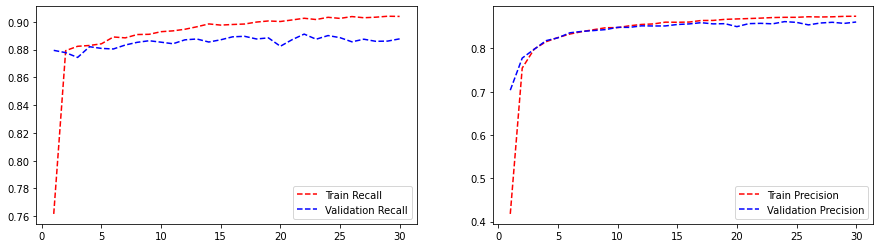

In [116]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_recall_vgg = history_vgg.history['recall']
val_recall_vgg = history_vgg.history['val_recall']

train_precision_vgg = history_vgg.history['precision']
val_precision_vgg = history_vgg.history['val_precision']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_precision_vgg, 'r--')
axs[0].plot(epoch_count, val_precision_vgg, 'b--')
axs[0].legend(['Train Recall', 'Validation Recall'])

axs[1].plot(epoch_count, train_recall_vgg, 'r--')
axs[1].plot(epoch_count, val_recall_vgg, 'b--')
axs[1].legend(['Train Precision', 'Validation Precision'])

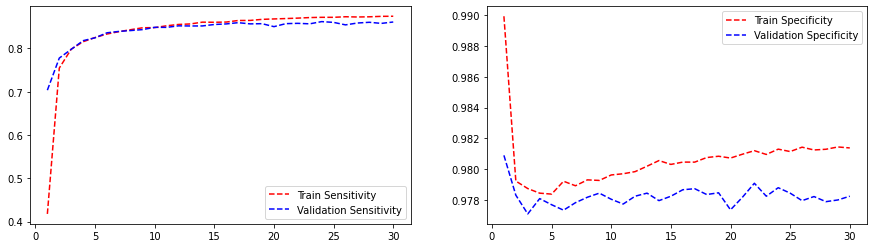

In [117]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_sensitivity_vgg = history_vgg.history['sensitivity']
val_sensitivity_vgg = history_vgg.history['val_sensitivity']

train_specificity_vgg = history_vgg.history['specificity']
val_specificity_vgg  = history_vgg.history['val_specificity']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_sensitivity_vgg, 'r--')
axs[0].plot(epoch_count, val_sensitivity_vgg, 'b--')
axs[0].legend(['Train Sensitivity', 'Validation Sensitivity'])

axs[1].plot(epoch_count, train_specificity_vgg, 'r--')
axs[1].plot(epoch_count, val_specificity_vgg, 'b--')
axs[1].legend(['Train Specificity', 'Validation Specificity'])

In [118]:
tf.keras.models.save_model(vgg_model, 'vgg_model.h5')

In [24]:
# vgg_model = tf.keras.models.load_model('vgg_model.h5', custom_objects= dependencies)

In [119]:
np.save('history_vgg.npy', history_vgg.history)

In [25]:
# history_vgg = np.load('history_vgg.npy', allow_pickle=True).item()

### ResNet50

In [120]:
from tensorflow.keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape = (150, 150, 3), include_top = False, weights = "imagenet")
resnet_base_model.trainable = False

inputs = tf.keras.Input(shape=(150,150,3))

x = resnet_base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(6, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs, outputs)

In [121]:
resnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_28 (Dense)            (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [122]:
resnet_model.compile(loss = "categorical_crossentropy", metrics = ['accuracy', sensitivity, precision,recall,specificity])

In [123]:
history_resnet = resnet_model.fit(train_data,
                    epochs = 30,
                    validation_data = test_data,
                    callbacks = reduce_learningRate,
                    )

Epoch 1/30
439/439 [==============================] - 21s 44ms/step - loss: 1.6235 - accuracy: 0.3561 - sensitivity: 0.0028 - precision: 0.0782 - recall: 0.0028 - specificity: 0.9997 - val_loss: 1.4953 - val_accuracy: 0.5033 - val_sensitivity: 0.0080 - val_precision: 0.2021 - val_recall: 0.0080 - val_specificity: 0.9990 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 18s 42ms/step - loss: 1.4328 - accuracy: 0.4766 - sensitivity: 0.0236 - precision: 0.4692 - recall: 0.0236 - specificity: 0.9984 - val_loss: 1.3712 - val_accuracy: 0.4753 - val_sensitivity: 0.0413 - val_precision: 0.6452 - val_recall: 0.0413 - val_specificity: 0.9977 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 19s 42ms/step - loss: 1.3283 - accuracy: 0.5180 - sensitivity: 0.0675 - precision: 0.7255 - recall: 0.0675 - specificity: 0.9965 - val_loss: 1.2825 - val_accuracy: 0.5310 - val_sensitivity: 0.0854 - val_precision: 0.7526 - val_recall: 0.0854 - val_specificity: 0.9959 - lr: 0.

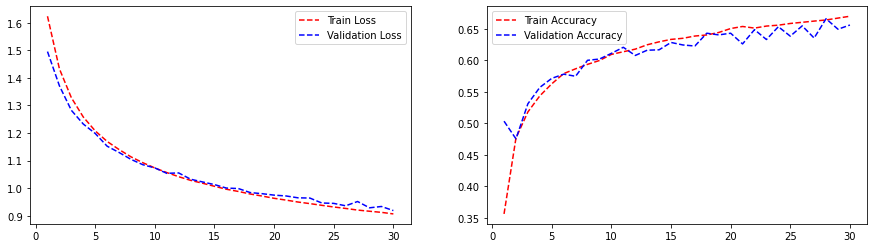

In [124]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_accuracy_resnet = history_resnet.history['accuracy']
val_accuracy_resnet= history_resnet.history['val_accuracy']

train_loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_loss_resnet, 'r--')
axs[0].plot(epoch_count, val_loss_resnet, 'b--')
axs[0].legend(['Train Loss', 'Validation Loss'])

axs[1].plot(epoch_count, train_accuracy_resnet, 'r--')
axs[1].plot(epoch_count, val_accuracy_resnet, 'b--')
axs[1].legend(['Train Accuracy', 'Validation Accuracy'])

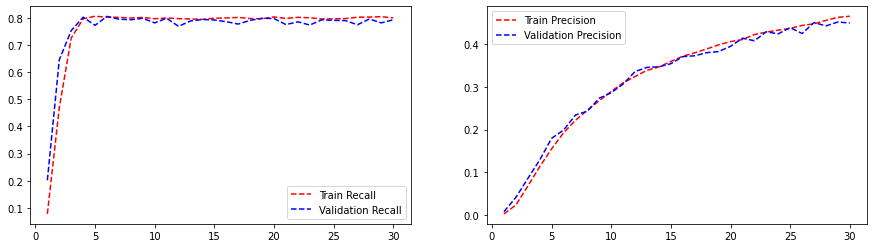

In [125]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_recall_resnet = history_resnet.history['recall']
val_recall_resnet = history_resnet.history['val_recall']

train_precision_resnet = history_resnet.history['precision']
val_precision_resnet = history_resnet.history['val_precision']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_precision_resnet, 'r--')
axs[0].plot(epoch_count, val_precision_resnet, 'b--')
axs[0].legend(['Train Recall', 'Validation Recall'])

axs[1].plot(epoch_count, train_recall_resnet, 'r--')
axs[1].plot(epoch_count, val_recall_resnet, 'b--')
axs[1].legend(['Train Precision', 'Validation Precision'])

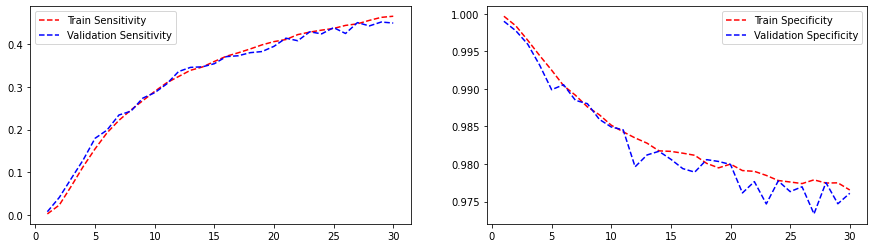

In [126]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

train_sensitivity_resnet = history_resnet.history['sensitivity']
val_sensitivity_resnet = history_resnet.history['val_sensitivity']

train_specificity_resnet = history_resnet.history['specificity']
val_specificity_resnet  = history_resnet.history['val_specificity']

epoch_count = range(1, len(train_loss) + 1)

axs[0].plot(epoch_count, train_sensitivity_resnet, 'r--')
axs[0].plot(epoch_count, val_sensitivity_resnet, 'b--')
axs[0].legend(['Train Sensitivity', 'Validation Sensitivity'])

axs[1].plot(epoch_count, train_specificity_resnet, 'r--')
axs[1].plot(epoch_count, val_specificity_resnet, 'b--')
axs[1].legend(['Train Specificity', 'Validation Specificity'])

In [ ]:
tf.keras.models.save_model(resnet_model, 'resnet_model.h5')

In [26]:
# resnet_model = tf.keras.models.load_model('resnet_model.h5', custom_objects= dependencies)

In [ ]:
np.save('history_resnet.npy', history_resnet.history)

In [28]:
# history_resnet = np.load('history_resnet.npy', allow_pickle=True).item()

## Comparing Loss and Accuracy

In [36]:
prediction_model = load_model.predict(pred_data)
prediction_inception = inception_model.predict(pred_data)
prediction_vgg = vgg_model.predict(pred_data)
prediction_resnet = resnet_model.predict(pred_data)

In [37]:
test_loss, test_accuracy, test_sensitivity, test_precision, test_recall, test_specificity = load_model.evaluate(pred_data, batch_size=32)
test_loss_inception, test_accuracy_inception, test_sensitivity_inception, test_precision_inception, test_recall_inception, test_specificity_inception = inception_model.evaluate(pred_data, batch_size=32)
test_loss_vgg, test_accuracy_vgg, test_sensitivity_vgg, test_precision_vgg, test_recall_vgg, test_specificity_vgg = vgg_model.evaluate(pred_data, batch_size=32)
test_loss_resnet, test_accuracy_resnet, test_sensitivity_resnet, test_precision_resnet, test_recall_resnet, test_specificity_resnet = resnet_model.evaluate(pred_data, batch_size=32)

94/94 [==============================] - 3s 31ms/step - loss: 0.9190 - accuracy: 0.6590 - sensitivity: 0.4477 - precision: 0.7886 - recall: 0.4477 - specificity: 0.9761


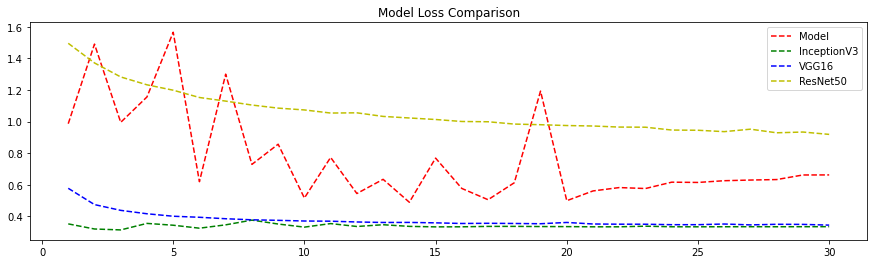

In [60]:
fig, axs = plt.subplots(1, figsize = (15, 4))


val_loss_model = history['val_loss']
val_loss_inception = history_inception['val_loss']
val_loss_vgg = history_vgg['val_loss']
val_loss_resnet = history_resnet['val_loss']

epoch_count = range(1, 31)

plt.title("Model Loss Comparison")
plt.plot(epoch_count, val_loss_model, 'r--')
plt.plot(epoch_count, val_loss_inception, 'g--')
plt.plot(epoch_count, val_loss_vgg, 'b--')
plt.plot(epoch_count, val_loss_resnet, 'y--')
plt.legend(['Model', 'InceptionV3', 'VGG16', 'ResNet50'])
plt.show()

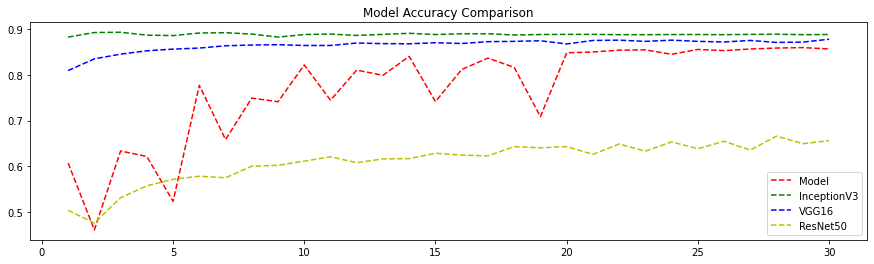

In [62]:
fig, axs = plt.subplots(1, figsize = (15, 4))


accuracy_model = history['val_accuracy']
accuracy_inception = history_inception['val_accuracy']
accuracy_vgg = history_vgg['val_accuracy']
accuracy_resnet = history_resnet['val_accuracy']

epoch_count = range(1, 31)

plt.title("Model Accuracy Comparison")
plt.plot(epoch_count, accuracy_model, 'r--')
plt.plot(epoch_count, accuracy_inception, 'g--')
plt.plot(epoch_count, accuracy_vgg, 'b--')
plt.plot(epoch_count, accuracy_resnet, 'y--')
plt.legend(['Model', 'InceptionV3', 'VGG16', 'ResNet50'])
plt.show()